# Online Retail EDA (with Python)

## Project Overview  

This project explores an **online retail transactions dataset**, focusing on **data cleaning, exploratory data analysis (EDA), and deriving business insights**. The dataset contains information about customer purchases, including invoice details, product descriptions, quantities, prices, and customer IDs. 


### Objectives  
- Perform **Exploratory Data Analysis (EDA)** to identify key trends.  
- Analyze **sales performance, customer behavior, and popular products**.  
- Provide **data-driven recommendations** to optimize online retail strategies.  


### My Approach  
To tackle this project, I’ll start by **ETL (Extract, Transform, Load)** to clean and prepare the dataset. Then, I’ll conduct in-depth analysis to identify key trends and insights like **busiest sales periods, top-selling products, and high-value customers**. Let's dive in!  


## Dataset Overview


For this project, I'll be working with the **Online Retail** dataset, which contains transactional data from an online store between 2010 and 2011. The dataset is in a `.csv` file named **`online_retail.csv`**, and it includes details about purchases such as product descriptions, quantities, prices, timestamps, and customer IDs.  


### Data Columns  
The dataset consists of the following fields:  
- **InvoiceNo** – Unique invoice number for each transaction.  
- **StockCode** – Unique product identifier.  
- **Description** – Product name/description.  
- **Quantity** – Number of units purchased.  
- **InvoiceDate** – Timestamp of the transaction.  
- **UnitPrice** – Price per unit of the product.  
- **CustomerID** – Unique identifier for each customer.  
- **Country** – Country where the transaction took place.  


Let's dive in and explore the dataset!  

### My Approach

To analyze this dataset effectively and derive meaningful insights, the workflow is divided into the following key stages:

1. **Load the Data**  
   Import the dataset into a Pandas DataFrame and inspect its structure and sample records.

2. **Data Cleaning**  
   Handle missing values, inconsistent entries, and remove irrelevant data to ensure accuracy.

3. **Basic Statistics**  
   Explore summary statistics to understand distributions and spot potential issues early on.

4. **Feature Engineering**  
   Create new variables such as `Revenue`, `InvoiceMonth`, and date-based features to enhance analysis.

5. **Exploratory Data Analysis (EDA)**  
   Investigate sales trends, customer behavior, product popularity, and country-wise performance.   
   Use charts (e.g., histograms, time series, bar plots) to better communicate patterns and findings.

6. **Insights and Recommendations**  
   Summarize key takeaways and provide actionable recommendations based on the analysis.

Let’s dive in and explore the dataset!



# ETL

## 1. Load the data

Import the required libraries and load the dataset.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns


In [3]:
df = pd.read_csv("source/online_retail.csv", encoding="ISO-8859-1")  # We use encoding to avoid UnicodeDecodeError (or encoding="Windows-1252")

Explore and familiarize with the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## 2. Data Cleaning

Now that we have identified the data types of each column and detected any missing (null) values, we have a clearer understanding of how to approach the ETL process.

Before proceeding, let's create a copy of the dataframe to preserve the original data in its unaltered state.

In [6]:
df_clean = df.copy()

### Type Casting

With the copy created, we will begin by modifying the data types of specific columns.  
In this case, we will convert the `Country`, `InvoiceNo`, and `StockCode` columns from the object type to the category type.  
This transformation will optimize memory usage and improve performance when handling these columns in Pandas.


In [7]:
df_clean['Country'] = df_clean['Country'].astype('category')
df_clean['InvoiceNo'] = df_clean['InvoiceNo'].astype('category')
df_clean['StockCode'] = df_clean['StockCode'].astype('category')

# Ensure the data types where set correctly with: df_clean.info()

After that, we can also make sure that CustomerID is `int` instead of `float` to help Pandas process the information more efficiently

In [8]:
df_clean['CustomerID'] = df_clean['CustomerID'].astype('Int64')

Finally, let's turn `InvoiceDate` to **datetime**

In [9]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

### Handling Missing Values

#### Handling missing `CustomerID` values

The dataset contains missing values in the `CustomerID` column, but these transactions are still valid purchases. Instead of dropping them or imputing arbitrary values (which could introduce bias), I will leave them as `NaN`.

 Why?
- Removing these rows would result in **loss of actual transaction data**.
- Imputing fake IDs would be **misleading**, as customer IDs are unique identifiers.
- Pandas and Matplotlib **handle NaN values gracefully** in most operations.

#### Handling missing `Description` values

The dataset contains null values in the `Description` column. Since these rows cannot be dropped without losing valuable data, we impute the missing descriptions using the corresponding `StockCode` values (which are complete and unique).

For that purpose, we follow this steps:
1. **Create a mapping dictionary** where each `StockCode` points to its correct `Description` (using only rows with non-null descriptions)
2. **Fill null values** by matching each missing `Description` with its `StockCode`'s known description

**Key Note**: If a `StockCode` has no valid description in the dataset, its `NaN` values will remain.

In [10]:
# Step 1: Map StockCode to Description (drop duplicates to ensure 1:1 mapping)
stock_to_desc = df_clean.dropna(subset=['Description']).drop_duplicates('StockCode').set_index('StockCode')['Description']

# Step 2: Fill NaN Descriptions using the mapped StockCode values
df_clean['Description'] = df_clean['Description'].fillna(df_clean['StockCode'].map(stock_to_desc))

After handling the preliminary missing values in the `Description` column, it's important to verify if any null values still remain. We will perform this check to ensure that all missing descriptions have been properly handled before moving forward with further analysis.

To do so, we'll check for any remaining nulls in the column.

In [11]:
# This will give us an updated count of the missing values in the 'Description' column
print(f'Original Description column null values: {df['Description'].isna().sum()}')
print(f'Updated Description column null values: {df_clean['Description'].isna().sum()}')

Original Description column null values: 1454
Updated Description column null values: 112


##### Imputing Remaining Null Values

After checking for null values, we found that 112 missing descriptions remain out of the initial 1,454 null values. To ensure we don't lose valuable transaction data, we will impute these remaining null values with the placeholder `'Unknown'`. This decision allows us to retain all rows in the dataset while clearly marking the transactions with missing descriptions.

In [12]:
df_clean['Description'] = df_clean['Description'].fillna('Unknown')

# To make sure this worked as intended: print(df_clean['Description'].isnull().sum())

By doing this, we preserve the full dataset while handling missing descriptions in a way that keeps the integrity of our analysis intact.

### String Processing

Before removing duplicates, we need to ensure that all truly identical rows are recognized as such by Pandas. To achieve this, we will standardize string formatting to eliminate inconsistencies.

We will focus on two key columns: `Description` and `Country`, as they contain string-type data.

`Description`: We will remove leading, trailing, and extra in-between whitespaces and standardize all text to uppercase for consistency.

`Country`: Similarly, we will trim unnecessary spaces and format country names in title case (first letter uppercase, the rest lowercase).

These transformations will help ensure that duplicate records are correctly identified and handled in the next step.

In [13]:
# Clean Description: Remove leading/trailing spaces, handle in-between extra spaces, and standardize to lowercase
df_clean['Description'] = df_clean['Description'].str.strip().str.replace(r'\s+', ' ', regex=True).str.upper()

# Clean Country: Remove leading/trailing spaces, handle in-between extra spaces, and title-case the country names
df_clean['Country'] = df_clean['Country'].str.strip().str.replace(r'\s+', ' ', regex=True).str.title()

### Removing Duplicates

Duplicated values can introduce bias and lead to incorrect insights, making it essential to handle them properly.

To begin, we will check for duplicate records in the dataset. Since individual columns may contain duplicate values, our focus will be on identifying and removing rows where all columns are identical.

For this, we will use Pandas' `.drop_duplicates()` method, which efficiently eliminates fully duplicated rows, ensuring data integrity for analysis.

In [14]:
print(f'Number of duplicate rows: {df_clean.duplicated().sum()}')

Number of duplicate rows: 5268


In [15]:
# Remove exact duplicate rows
df_clean = df_clean.drop_duplicates()

### Validating Negative Values

Based on the results of `df.describe()` in the *Load the Data* step, we identified negative values in the `Quantity` and `UnitPrice` columns. Since these values are not expected in a standard sales dataset, we will handle them systematically.

In [16]:
# Check for negative values in Quantity and UnitPrice
print(df_clean[df_clean['Quantity'] < 0].shape[0])
print(df_clean[df_clean['UnitPrice'] < 0].shape[0])

10587
2


Since the number of negative values in the `Quantity` column is significantly higher, we will address them first.

#### Analizing the negative values in `Quantity`

In [17]:
# Take a look at the negative values in Quantity and look for patterns
df_clean[df_clean['Quantity'] < 0].sample(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
72927,C542273,20980,36 PENCILS TUBE POSY,-9,2011-01-27 10:01:00,1.25,12578,Italy
378655,C569655,22992,REVOLVER WOODEN RULER,-3,2011-10-05 12:58:00,1.95,14534,United Kingdom
255772,559365,22451,SILK PURSE BABUSHKA RED,-3,2011-07-08 08:53:00,0.00,<NA>,United Kingdom
272157,560737,84798B,PURPLE FOXGLOVE ARTIIFCIAL FLOWER,-109,2011-07-20 15:34:00,0.00,<NA>,United Kingdom
11799,C537314,21349,IVY HEART WREATH,-4,2010-12-06 11:42:00,6.75,13497,United Kingdom
122197,C546854,20726,LUNCH BAG WOODLAND,-1,2011-03-17 13:55:00,1.45,17511,United Kingdom
414584,C572469,85099B,JUMBO BAG RED RETROSPOT,-1,2011-10-24 13:31:00,2.08,13534,United Kingdom
397673,C571196,20727,LUNCH BAG BLACK SKULL.,-10,2011-10-14 12:02:00,1.65,<NA>,United Kingdom
418095,572693,35810A,CHECK,-78,2011-10-25 14:20:00,0.00,<NA>,United Kingdom
22534,538173,22353,LUNCH BOX WITH CUTLERY FAIRY CAKES,-28,2010-12-10 09:35:00,0.00,<NA>,United Kingdom


Upon examining the data, we can observe some patterns:  

1. Most `InvoiceNo` values associated with negative quantities begin with "C," which likely indicates a **credit transaction** (returns).  
2. Some `Description` values suggest special cases, such as "DAMAGED," "DISCOUNT," or "?".  

To better understand these cases, we will analyze how many unique `Description` values are associated with negative quantities.


In [18]:
negative_descriptions = df_clean[df_clean['Quantity'] < 0]['Description'].value_counts()
print(negative_descriptions.count())

2471


Given the large number of unique descriptions associated with negative quantities, we will focus on the most frequently occurring ones. This will help us identify common patterns and determine which descriptions may represent special cases that require specific handling.

In [19]:
print(negative_descriptions.head(30))  # Show the top 30 most frequent negative descriptions

Description
MANUAL                                 244
REGENCY CAKESTAND 3 TIER               180
POSTAGE                                126
CHECK                                  123
UNKNOWN                                 97
JAM MAKING SET WITH JARS                87
DISCOUNT                                77
SET OF 3 CAKE TINS PANTRY DESIGN        75
SAMPLES                                 61
DAMAGED                                 57
STRAWBERRY CERAMIC TRINKET BOX          54
ROSES REGENCY TEACUP AND SAUCER         54
RECIPE BOX PANTRY YELLOW DESIGN         47
DAMAGES                                 46
JUMBO BAG RED RETROSPOT                 44
LUNCH BAG RED RETROSPOT                 44
WOOD 2 DRAWER CABINET WHITE FINISH      43
RED RETROSPOT CAKE STAND                42
WHITE HANGING HEART T-LIGHT HOLDER      42
GREEN REGENCY TEACUP AND SAUCER         42
?                                       42
SMALL GLASS HEART TRINKET POT           40
SET OF 3 REGENCY CAKE TINS              37

#### Handling the negative values in `Quantity`

The output shows that some `Description` values represent regular products, while others indicate special cases (discounts, damaged products, or ambiguous values like "?"). We implement a unified classification system:

1. Categorize All Transactions

    Create a `TransactionType` column with three distinct labels:

    * **Return:** Transactions where `InvoiceNo` starts with "C" (credit notes).
    * **SpecialCase:** Transactions with descriptions matching predefined non-product terms (DISCOUNT, DAMAGED, SAMPLES, ?, etc.).
    * **Sale:** All other regular transactions.

2. Process Negative Quantities

    * **Returns:** Keep negatives (valid refund records).
    * **Special Cases:** Preserve original values (context-dependent).
    * **Sales:** Convert negatives to positives (assumed data entry errors).

**Note:** To distinguish legitimate negative quantities from data entry errors:

* Identified the top 30 most frequent descriptions for negative quantities

* Manually selected non-product terms (e.g., `DISCOUNT`, `DAMAGED`, `?`)

Resulting in the curated `special_case_list` used for classification.

In [20]:
# Predefined list of special cases for descriptions
special_case_list = [
    'DISCOUNT', 'DAMAGED', 'DAMAGES', 'SAMPLES', 'CHECK', 'MANUAL', 'POSTAGE', 
    'UNKNOWN', '?', 'AMAZON FEE', 'DOTCOM POSTAGE'
]

In [21]:
def classify_transaction(invoice_no, description):
    """Classify transaction as 'Return', 'SpecialCase', or 'Sale'."""
    if str(invoice_no).startswith('C'):
        return 'Return'
    elif description in special_case_list:
        return 'SpecialCase'
    else:
        return 'Sale'

# Use .map() efficiently by applying it on a tuple of (InvoiceNo, Description)
df_clean['TransactionType'] = list(map(classify_transaction, df_clean['InvoiceNo'], df_clean['Description']))

In [22]:
# Convert negatives to positives ONLY for regular Sales
df_clean.loc[
    (df_clean['TransactionType'] == 'Sale') & 
    (df_clean['Quantity'] < 0), 
    'Quantity'
] = df_clean['Quantity'].abs()  # Or: *= -1

To verify this approach worked as intended, we check if there are any negative `Quantity` values remaining that are neither classified as "Return" nor "SpecialCase".

In [23]:
print(f"Non Return or SpecialCase negative `Quantity` values: {df_clean[
    (df_clean['Quantity'] < 0) & 
    (~df_clean['TransactionType'].isin(['Return', 'SpecialCase']))
].shape[0]}")

Non Return or SpecialCase negative `Quantity` values: 0


Since the result is 0, it confirms that all negative `Quantity` values have been correctly handled according to our classification. We can now proceed to the next step.

#### Analizing and handling the negative values in `UnitPrice`

As observed earlier, only two transactions have negative `UnitPrice` values. Given their small number, we can inspect them directly as follows:

In [24]:
df_clean[df_clean['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionType
299983,A563186,B,ADJUST BAD DEBT,1,2011-08-12 14:51:00,-11062.06,<NA>,United Kingdom,Sale
299984,A563187,B,ADJUST BAD DEBT,1,2011-08-12 14:52:00,-11062.06,<NA>,United Kingdom,Sale


Since they are labeled as "ADJUST BAD DEBT," these transactions appear to represent financial adjustments rather than product sales.

As these records are valid, we will keep them in the dataset and classify them under "SpecialCase" in the `TransactionType` column while preserving their negative values.


In [25]:
# Ensure "ADJUST BAD DEBT" transactions are marked as SpecialCase
df_clean.loc[df_clean['Description'] == 'ADJUST BAD DEBT', 'TransactionType'] = 'SpecialCase'

### Handling Outliers

The output from our initial exploration of `UnitPrice` shows that some transactions contain exceptionally high values. Upon further inspection, we found that several of these do not represent actual product sales but rather special cases, such as fees, postage, or adjustments.

1. Identifying High `UnitPrice` Transactions
To detect potential outliers, we examined the top transactions sorted by `UnitPrice`:

- Initially, we used `df_clean.nlargest(10, 'UnitPrice')` to inspect the highest values.

- Many high `UnitPrice` values corresponded to non-product transactions, which are **not currently classified as SpecialCases** (e.g., "DOTCOM POSTAGE", "THROW AWAY", "MOULDY, THROWN AWAY.").

- To refine our analysis, we iteratively excluded known non-product descriptions and re-ran the analysis to identify remaining cases.

In [26]:
df_clean.nlargest(10, 'UnitPrice')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionType
222681,C556445,M,MANUAL,-1,2011-06-10 15:31:00,38970.00,15098,United Kingdom,Return
524602,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.46,<NA>,United Kingdom,Return
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,<NA>,United Kingdom,Return
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,<NA>,United Kingdom,Return
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,<NA>,United Kingdom,Return
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,<NA>,United Kingdom,SpecialCase
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,<NA>,United Kingdom,Return
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,<NA>,United Kingdom,Return
524601,C580604,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:35:00,11586.50,<NA>,United Kingdom,Return
299982,A563185,B,ADJUST BAD DEBT,1,2011-08-12 14:50:00,11062.06,<NA>,United Kingdom,SpecialCase


2. Filtering Out Non-Product Cases
We applied a filtering step to exclude descriptions that represent fees, adjustments, or other special cases, ensuring that we focus on actual product-related outliers. The filtered descriptions include:

    "AMAZON FEE", "MANUAL", "DOTCOM POSTAGE", "BANK CHARGES", "ADJUST BAD DEBT", "POSTAGE", "DISCOUNT", "CRUK COMMISSION"

In [27]:
df_clean[~df_clean['Description'].isin(
    ["AMAZON FEE", "MANUAL", 'DOTCOM POSTAGE', 'BANK CHARGES', 'ADJUST BAD DEBT', 'POSTAGE', 'DISCOUNT', 'CRUK COMMISSION' 
    ])].nlargest(10, 'UnitPrice')

# 'DOTCOM POSTAGE', 'THROW AWAY', 'UNSALEABLE, DESTROYED.', 'MOULDY, THROWN AWAY.'

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionType
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098,United Kingdom,Sale
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098,United Kingdom,Sale
242589,C558359,S,SAMPLES,-1,2011-06-28 15:10:00,570.0,<NA>,United Kingdom,Return
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145,United Kingdom,Sale
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607,United Kingdom,Sale
36165,C539438,22655,VINTAGE RED KITCHEN CABINET,-1,2010-12-17 15:11:00,295.0,16607,United Kingdom,Return
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406,United Kingdom,Sale
82768,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.0,14842,United Kingdom,Sale
87141,C543632,22655,VINTAGE RED KITCHEN CABINET,-1,2011-02-10 16:22:00,295.0,14842,United Kingdom,Return
118769,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.0,13452,United Kingdom,Sale


To handle the identified outliers, we expand the `special_case_list` to include these descriptions and reuse the `classify_transaction` function, ensuring they are correctly categorized in the dataset.

In [28]:
# Expanding the special_case_list with newly identified non-product descriptions
special_case_list.extend([
    "DOTCOM POSTAGE", "THROW AWAY", "UNSALEABLE, DESTROYED.", "MOULDY, THROWN AWAY.",
    "AMAZON FEE", "MANUAL", "BANK CHARGES", "ADJUST BAD DEBT", "POSTAGE", "DISCOUNT", "CRUK COMMISSION"
])

# Reapplying the classification function to update TransactionType
df_clean['TransactionType'] = list(map(classify_transaction, df_clean['InvoiceNo'], df_clean['Description']))


Then, we can re-run the high `UnitPrice`analysis to confirm that all outliers are either properly classified or remain legitimate product sales.

By implementing this refined approach, we ensure that outlier removal is not arbitrary but instead data-driven, focusing on legitimate product transactions while flagging non-product entries as SpecialCases.

In [29]:
df_clean.nlargest(10, 'UnitPrice')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionType
222681,C556445,M,MANUAL,-1,2011-06-10 15:31:00,38970.00,15098,United Kingdom,Return
524602,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.46,<NA>,United Kingdom,Return
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,<NA>,United Kingdom,Return
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,<NA>,United Kingdom,Return
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,<NA>,United Kingdom,Return
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,<NA>,United Kingdom,SpecialCase
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,<NA>,United Kingdom,Return
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,<NA>,United Kingdom,Return
524601,C580604,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:35:00,11586.50,<NA>,United Kingdom,Return
299982,A563185,B,ADJUST BAD DEBT,1,2011-08-12 14:50:00,11062.06,<NA>,United Kingdom,SpecialCase


## 3. Basic Statistics

After cleaning the dataset, we proceed to explore its basic statistics. This initial analysis provides a foundation for understanding the data’s structure, identifying early patterns, and evaluating potential anomalies or irregularities. It sets the stage for more advanced analytical steps by offering a general snapshot of the dataset’s composition.

We begin by generating summary statistics and exploring key aspects of the data.

In [30]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   InvoiceNo        536641 non-null  category      
 1   StockCode        536641 non-null  category      
 2   Description      536641 non-null  object        
 3   Quantity         536641 non-null  int64         
 4   InvoiceDate      536641 non-null  datetime64[ns]
 5   UnitPrice        536641 non-null  float64       
 6   CustomerID       401604 non-null  Int64         
 7   Country          536641 non-null  object        
 8   TransactionType  536641 non-null  object        
dtypes: Int64(1), category(2), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 52.8+ MB


**Key Observations:**

- **Rows**: 536,641 transactions
- **Columns**: 9
- Missing Values: Most columns are complete, except for CustomerID, which is missing in approximately 25% of the records
- **Derived Column**: A new column, `TransactionType`, classifies each row as a `Sale`, `Return`, or `SpecialCase` based on invoice patterns and product descriptions

In [31]:
df_clean['TransactionType'].value_counts(normalize=True)

TransactionType
Sale           0.977879
Return         0.017239
SpecialCase    0.004882
Name: proportion, dtype: float64

The majority of transactions are regular **Sales**, followed by a smaller proportion of **Returns** and **Special Cases**, as expected based on our previous classification process.

### Overview of each transaction type

Having all transactions categorized under `TransactionType`, we can now analyze each group independently without conflating their behaviors. This allows for more accurate insights and better handling of specific cases.

To begin, we use the `.describe()` method to generate summary statistics for each transaction type.

In [32]:
df_clean[df_clean['TransactionType'] == 'Sale'].drop(columns=['CustomerID']).describe()

,Quantity,InvoiceDate,UnitPrice
count,524770.000000,524770,524770.000000
mean,10.987383,2011-07-04 13:00:30.277493504,3.274727
min,1.000000,2010-12-01 08:26:00,0.000000
25%,1.000000,2011-03-28 11:51:00,1.250000
50%,4.000000,2011-07-19 17:17:00,2.080000
75%,12.000000,2011-10-19 10:59:00,4.130000
max,80995.000000,2011-12-09 12:50:00,649.500000
std,159.878853,NaN,4.460465


In [33]:
df_clean[df_clean['TransactionType'] == 'Return'].drop(columns=['CustomerID']).describe()

,Quantity,InvoiceDate,UnitPrice
count,9251.000000,9251,9251.000000
mean,-29.787050,2011-06-26 07:06:45.231866880,48.570430
min,-80995.000000,2010-12-01 09:41:00,0.010000
25%,-6.000000,2011-03-21 16:26:00,1.450000
50%,-2.000000,2011-07-08 13:04:00,2.950000
75%,-1.000000,2011-10-06 20:36:00,5.950000
max,-1.000000,2011-12-09 11:58:00,38970.000000
std,1147.997592,NaN,667.926393


In [34]:
df_clean[df_clean['TransactionType'] == 'SpecialCase'].drop(columns=['CustomerID']).describe()

,Quantity,InvoiceDate,UnitPrice
count,2620.000000,2620,2620.000000
mean,4.115649,2011-06-29 00:50:42.847328256,121.476855
min,-3000.000000,2010-12-01 08:45:00,-11062.060000
25%,1.000000,2011-03-25 14:14:15,2.950000
50%,1.000000,2011-07-05 17:01:00,18.000000
75%,2.000000,2011-10-13 16:19:45,118.342500
max,5368.000000,2011-12-09 12:16:00,13541.330000
std,232.965881,NaN,580.267542


**Key Takeaways:**

- **Returns** correctly reflect negative quantities, consistent with refund transactions.
- **Special Cases** exhibit high variability in both `Quantity` and `UnitPrice`, supporting their exclusion from regular sales analysis.
- **Sales** now contain only positive quantities and show a reasonable distribution of unit prices, indicating reliable data for core business analysis.


## 4. Feature Engineering

In this section, we enrich our dataset by creating new, meaningful features that will support future exploratory analysis and help uncover deeper insights.

The main goals of this step are to:

- Create a Revenue column to measure transaction value.
- Extract time-based features from the invoice date to enable seasonality and behavior analysis.
- Engineer RFM (Recency, Frequency, Monetary) features to evaluate customer behavior and segment them based on purchasing patterns.

These engineered features will serve as a strong foundation for both exploratory data analysis (EDA) and potential modeling in future steps.

We begin by creating a `Revenue` column for each transaction by multiplying `Quantity` by `UnitPrice`. This serves as the foundation for later customer value analysis.

In [35]:
df_clean['Revenue'] = df_clean['Quantity'] * df_clean['UnitPrice']

To enable temporal analysis, we extract multiple date and time features from the `InvoiceDate` column. These will be useful for analyzing seasonality, trends, and customer behavior over time.

In [36]:
df_clean['InvoiceYear'] = df_clean['InvoiceDate'].dt.year
df_clean['InvoiceMonth'] = df_clean['InvoiceDate'].dt.month
df_clean['InvoiceDay'] = df_clean['InvoiceDate'].dt.day
df_clean['InvoiceHour'] = df_clean['InvoiceDate'].dt.hour
df_clean['InvoiceWeekday'] = df_clean['InvoiceDate'].dt.day_name()
df_clean['YearMonth'] = df_clean['InvoiceDate'].dt.to_period('M').dt.to_timestamp()

### RFM analysis feature engineering

To enhance our understanding of customer behavior, we’ll perform a **RFM (Recency, Frequency, Monetary) analysis** — a well-established method for customer segmentation based on purchasing patterns.

Since RFM relies on the `CustomerID` column, and we intentionally retained null values in our main dataset (`df_clean`) to avoid bias in other analyses, we’ll work with a filtered copy. This new DataFrame, `notnull_customer_df`, includes only sales transactions with valid `CustomerID` values to ensure accurate segmentation.

Additionally, RFM analysis requires a reference point in time to calculate `Recency`. We'll define this reference date as one day after the most recent InvoiceDate in the dataset.

We filter the dataset to include only regular sales (`TransactionType == 'Sale'`) and transactions with known `CustomerID`. This ensures a reliable and unbiased base for calculating RFM metrics.

In [37]:
notnull_customer_df = df_clean[
    (df_clean['TransactionType'] == 'Sale') &
    (df_clean['CustomerID'].notnull())
].copy()

To compute the **Recency** metric (how recently each customer purchased), we define a `reference_date` as one day after the most recent invoice in the dataset.

In [38]:

#Select the reference date for RFM analysis
reference_date = notnull_customer_df['InvoiceDate'].max() + pd.Timedelta(days=1)

To calculate RFM metrics, we group transactions by CustomerID and compute the three core RFM metrics:

- **Recency**: Days since last purchase
- **Frequency**: Number of unique invoices (transactions)
- **Monetary**: Total revenue generated

In [39]:
# 1. Group by CustomerID and aggregate Recency, Frequency, Monetary
df_rfm = notnull_customer_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,            # Recency
    'InvoiceNo': 'nunique',                                              # Frequency
    'UnitPrice': 'sum'                                                   # Temporary, we'll correct this below
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
})

# Replace the placeholder UnitPrice sum with actual customer revenue using the Revenue column
df_rfm['Monetary'] =  notnull_customer_df.groupby('CustomerID')['Revenue'].sum()


Let's review summary statistics for the RFM features to understand their ranges, distributions, and central tendencies.

In [40]:
df_rfm.describe()

,Recency,Frequency,UnitPrice,Monetary
count,4335.000000,4335.000000,4335.000000,4335.000000
mean,92.684890,4.246367,260.894753,2017.050437
std,100.172622,7.643880,697.201332,8919.387033
min,1.000000,1.000000,0.000000,0.000000
25%,18.000000,1.000000,48.850000,304.250000
50%,51.000000,2.000000,120.950000,663.610000
75%,143.000000,5.000000,277.860000,1631.475000
max,374.000000,206.000000,22776.010000,279138.020000


# Exploratory Data Analysis **(EDA)**

In this section, we explore the dataset to better understand its structure, surface key trends, detect anomalies, and uncover actionable insights. This process includes both numerical and visual analysis to evaluate customer behavior, product performance, and sales dynamics.

By combining statistical summaries with data visualizations, we aim to generate meaningful interpretations that will support data-driven business decision-making.

## Sales Performance Overview

This section provides a comprehensive look into the company’s sales performance across multiple dimensions. We'll take a holistic approach by examining **transaction types**, **geographic distribution**, **product demand**, and **return patterns**. This multi-layered exploration helps us spot trends, identify potential issues, and understand how customer behavior and operational processes influence the business over time.

We start by reviewing **monthly trends in revenue and returns**, then explore **country-level performance**, highlight the **top-performing markets**, and finally investigate **product-level sales behavior** and **return volumes by transaction type**. Each visualization offers a distinct angle on the sales ecosystem, working together to reveal both high-level patterns and granular insights.

> ⚠️ **Note:** The dataset ends on **December 9th, 2011**, so data for December should be treated as **partial and not representative** of a full month.

### Monthly Trends by Transaction Type


First, let’s take a look at how each transaction type — **Sales**, **Returns**, and **Special Cases** — evolved over time. This view helps us understand the overall business flow, seasonal patterns, and the relative impact of each type on monthly performance.

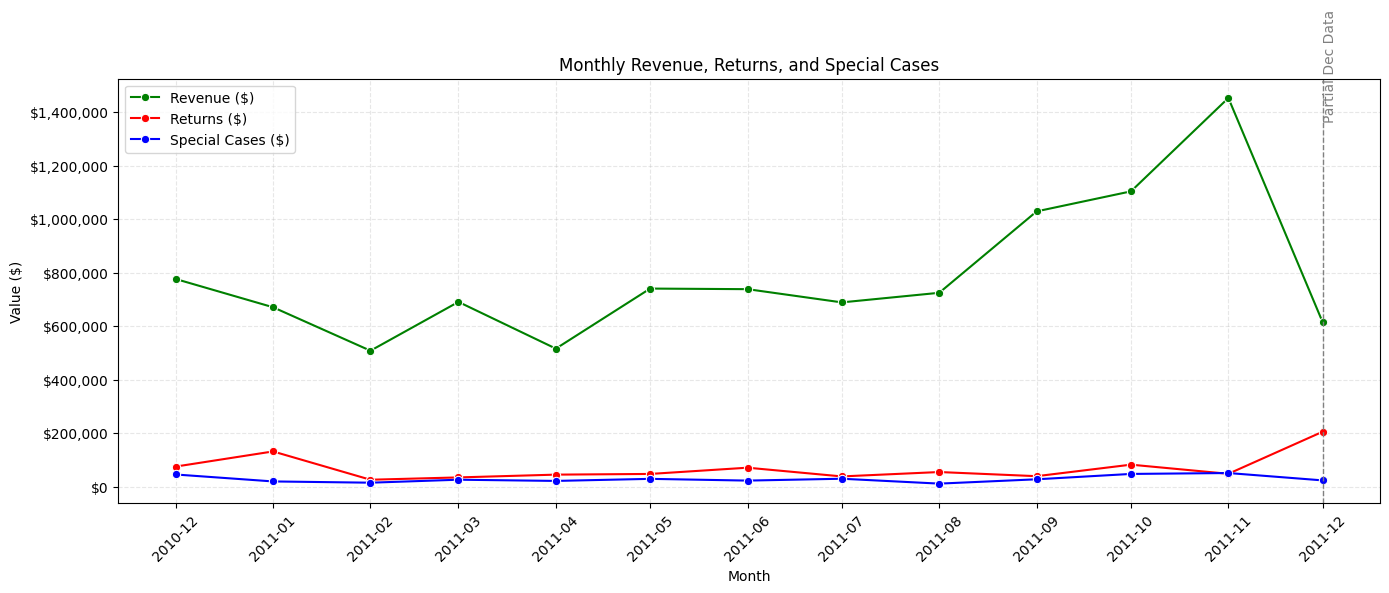

In [41]:
# Aggregate Revenue, Returns, and SpecialCases
monthly_trend = (
    df_clean
    .groupby(['YearMonth', 'TransactionType'])['Revenue']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={'Sale': 'Revenue', 'Return': 'Returns', 'SpecialCase': 'SpecialCases'})
)

# Plotting all three transaction types
plt.figure(figsize=(14, 6))

sns.lineplot(data=monthly_trend, x='YearMonth', y='Revenue', marker='o', label='Revenue ($)', color='green')
sns.lineplot(data=monthly_trend, x='YearMonth', y=monthly_trend['Returns'].abs(), marker='o', label='Returns ($)', color='red')
sns.lineplot(data=monthly_trend, x='YearMonth', y='SpecialCases', marker='o', label='Special Cases ($)', color='blue')

# Annotations and formatting
plt.title('Monthly Revenue, Returns, and Special Cases')
plt.xlabel('Month')
plt.ylabel('Value ($)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Format the Y axis to show currency
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Highlight December 2011 as partial data
plt.axvline(pd.to_datetime('2011-12-01'), color='gray', linestyle='--', linewidth=1)
plt.text(pd.to_datetime('2011-12-01'), plt.ylim()[1]*0.9, 'Partial Dec Data', rotation=90, color='gray')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


**Key Insights from Monthly Revenue, Returns, and Special Cases**

1. **Sales Peak in November**  
   Revenue steadily increased through most of 2011, reaching a significant peak in **November 2011** with over **$1.45M** in sales. This likely reflects **holiday season demand**, as the spike aligns with common retail trends.

2. **Returns Spike in December**  
   The most substantial return value appears in **December 2011**, with **-$205K**, despite having **incomplete sales data**. This could indicate post-November returns or refunds, emphasizing the need for **return management** strategies after major sales periods.

3. **Relatively Stable Special Cases**  
   Special case transactions remained relatively low and stable month-to-month, ranging from **$11K to $50K**, with a modest peak in **November**. These may represent adjustments, manual corrections, or other non-standard activities that have a small but consistent footprint.

4. **Sales Growth Across the Year**  
   Revenue grew from **$776K in Dec 2010** to a high of **$1.45M in Nov 2011**, nearly **doubling** over the course of the year. This suggests strong business momentum and increasing demand.

5. **Sales Dip in Early Months**  
   Revenue saw a dip in **February 2011** ($508K), possibly due to **post-holiday slowdowns**. However, it recovered quickly by **March and May**, continuing its upward trajectory.

6. **Returns Fluctuate Without Direct Correlation to Sales**  
   While some months show higher returns accompanying high sales (e.g., January, June), others (like November) had high revenue but **relatively moderate returns**, which could indicate **better product satisfaction or retention** during that period.

### Revenue by Country 

After analyzing the monthly revenue trends, it's equally important to understand **where the revenue is coming from**. The following chart focuses on the top-performing countries in terms of revenue, helping us identify the most valuable markets and prioritize efforts accordingly.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19932\361944666.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=top_countries_df, x='Revenue', y='Country', palette='viridis')


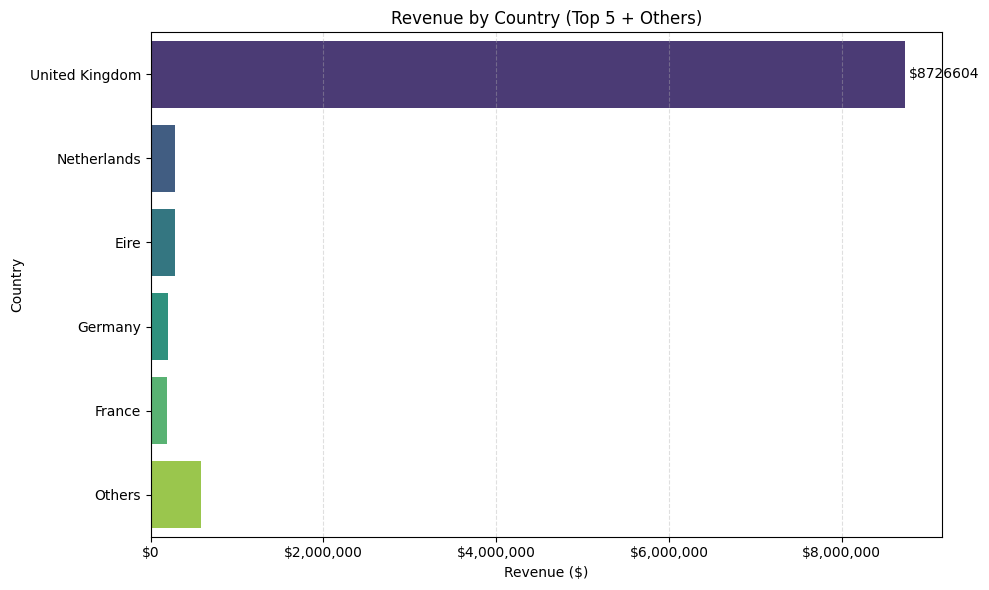

In [42]:
# Aggregate revenue and prepare top 5 + Others
revenue_by_country = (
    df_clean[df_clean["TransactionType"] == "Sale"]
    .groupby("Country")["Revenue"]
    .sum()
    .sort_values(ascending=False)
)

top_5_countries = revenue_by_country.head(5)
others = revenue_by_country.iloc[5:].sum()
revenue_combined = pd.concat([top_5_countries, pd.Series({'Others': others})])

# Prepare DataFrame for Seaborn
top_countries_df = revenue_combined.reset_index()
top_countries_df.columns = ['Country', 'Revenue']

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=top_countries_df, x='Revenue', y='Country', palette='viridis')

# Add value labels
barplot.bar_label(barplot.containers[0], fmt='$%d', label_type='edge', padding=3)

# Format x-axis
barplot.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Final touches
plt.title('Revenue by Country (Top 5 + Others)')
plt.xlabel('Revenue ($)')
plt.ylabel('Country')
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Key Insights – Revenue by Country**

- **The United Kingdom** alone generated over **$8.7 million**, which accounts for **nearly 85%** of total revenue — clearly the company’s core market.
- The next highest contributors — **Netherlands, Ireland (Eire), Germany, and France** — combined brought in under **$1 million**, highlighting a steep drop after the UK.
- The **“Others” category**, which aggregates revenue from over 30 countries, generated **$578K**, which is still less than the revenue from the UK alone.
- These figures suggest that while international sales exist, the business is **heavily dependent on the UK**, and expanding in high-performing countries like the Netherlands and Eire could be a strategic opportunity.

Let me know when you're ready to jump into the next chart — top-selling products or returns over time?

### Top Products

Here, we'll take a look at the **top-selling** products by both *quantity sold* and *total revenue*

#### By Quantity

Next, we’ll look at the **top-selling products by quantity** to identify which items drive the highest sales volume. This can offer insights into customer preferences, product popularity, and inventory planning.


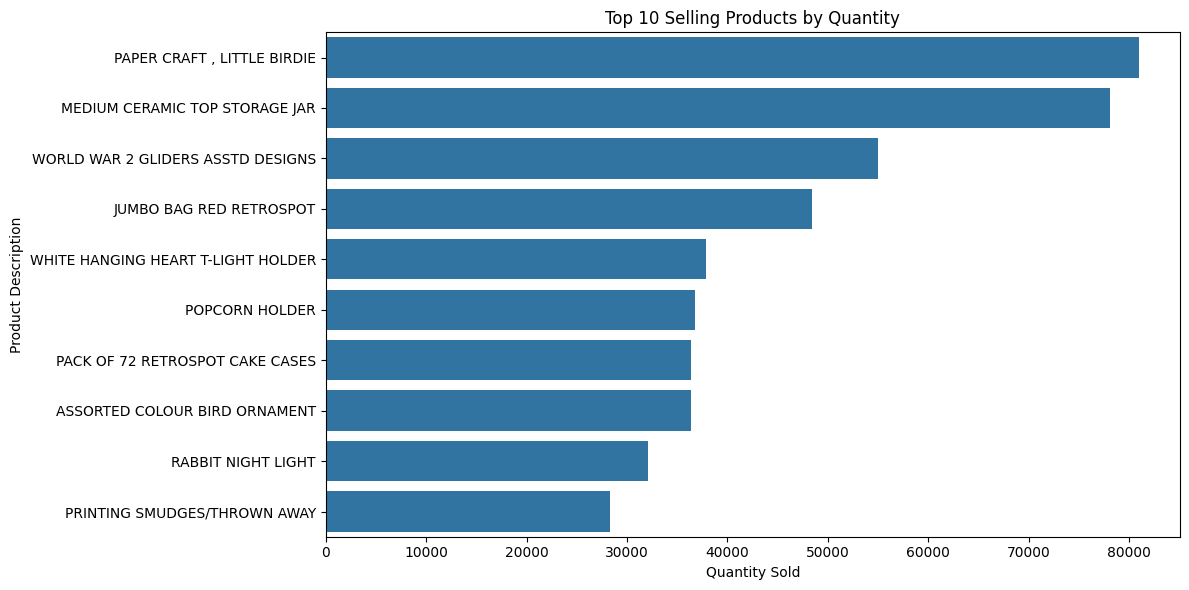

In [43]:
top_products_quantity = df_clean[df_clean["TransactionType"] == "Sale"] \
    .groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_products_quantity.values, y=top_products_quantity.index, orient='h')
plt.title("Top 10 Selling Products by Quantity")
plt.xlabel("Quantity Sold")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()


**Key Insights – Top-Selling Products**

- **"PAPER CRAFT , LITTLE BIRDIE"** leads the chart by a significant margin with over **80,000 units sold**, making it the single most popular item by quantity.
- Close behind is the **"MEDIUM CERAMIC TOP STORAGE JAR"** with over **78,000 units**, suggesting a strong market for decorative or storage-related items.
- Toys and novelty products like **"WORLD WAR 2 GLIDERS ASSTD DESIGNS"** and **"RABBIT NIGHT LIGHT"** also appear in the top 10, indicating demand for **giftable and playful products**.
- The presence of **"PRINTING SMUDGES/THROWN AWAY"** in the top list might indicate a **data quality issue or a process gap** that needs to be addressed, as this likely reflects faulty or discarded inventory.

#### By Revenue

While quantity tells us which products are most frequently sold, analyzing revenue reveals which items bring in the most money. Let’s now explore the **top products by revenue** to understand which items are the most financially impactful.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19932\1516279250.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products_revenue, x='Revenue', y='Description', palette='viridis')


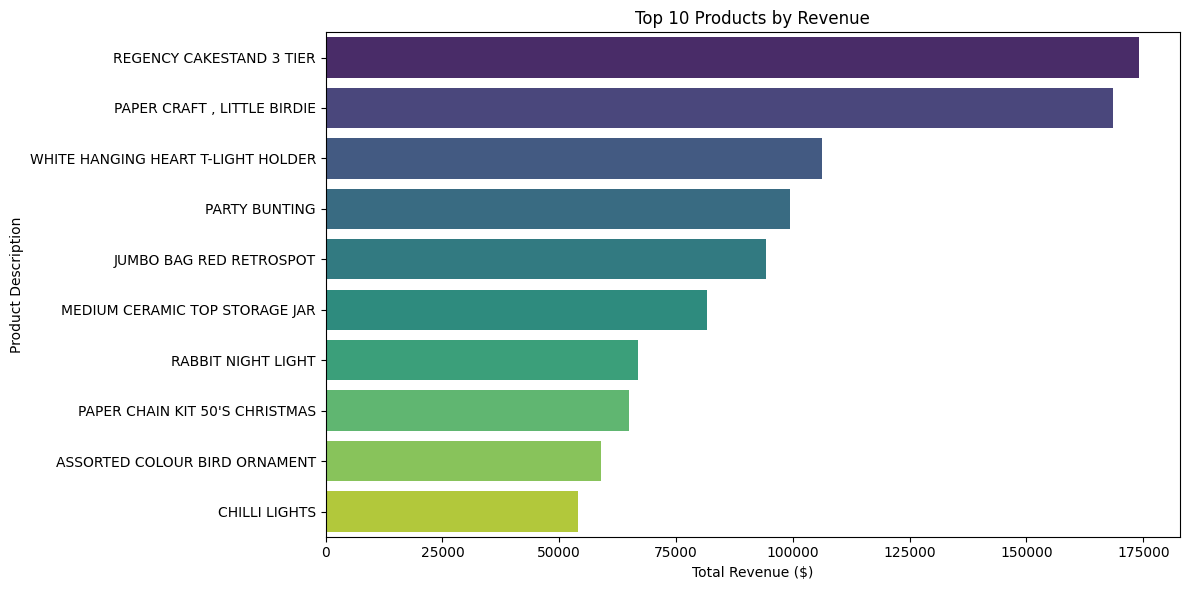

In [44]:
top_products_revenue = (
    df_clean[df_clean['TransactionType'] == 'Sale']
    .groupby('Description')['Revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products_revenue, x='Revenue', y='Description', palette='viridis')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue ($)')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()


**Key Insights:**

- **REGENCY CAKESTAND 3 TIER** leads all products with over **$174K** in revenue, likely due to its high unit price rather than sheer sales volume.
- **PAPER CRAFT , LITTLE BIRDIE**, which also led in total units sold, ranks second in revenue—demonstrating strong performance both in volume and value.
- Several decor and gift items such as **WHITE HANGING HEART T-LIGHT HOLDER**, **RABBIT NIGHT LIGHT**, and **CHILLI LIGHTS** make the list, suggesting a customer preference for charming and whimsical home items.
- **PARTY BUNTING** and **PAPER CHAIN KIT 50'S CHRISTMAS** show strong seasonal or celebratory product demand.
- High overlap with the “Top Products by Quantity” plot suggests a set of **best-sellers driving both volume and revenue**, which could inform future promotional strategies or inventory planning.

### Average Order Value **(AOV)**

The **Average Order Value** is a key performance indicator that shows the average revenue generated per transaction. A higher AOV suggests that customers tend to purchase more per order or higher-value items.


In [45]:
# Filter only sales transactions
df_sales = df_clean[df_clean['TransactionType'] == 'Sale']

# Compute AOV
total_revenue = df_sales['Revenue'].sum()
total_orders = df_sales['InvoiceNo'].nunique()
average_order_value = total_revenue / total_orders

print(f'${average_order_value:.2f}')


$478.26


- The **Average Order Value** across all transactions is **$478.26**, indicating that, on average, each invoice contributes close to **$500** to the overall revenue.
- This metric serves as a useful benchmark when evaluating high-value customers or potential upselling strategies.

### Top Customers

To further understand customer performance, we analyzed the top customers both by total revenue and by number of orders. These plots highlight which customers contributed the most revenue and which made the most purchases. This can help identify high-value and highly engaged customers.

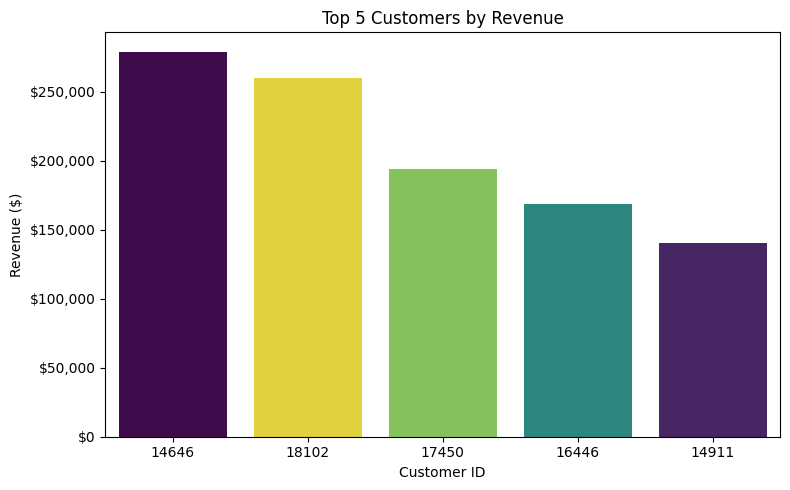

In [46]:
# Group by CustomerID and sum Revenue
top_customers_by_revenue = (
    df_sales.groupby('CustomerID')['Revenue']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)
# Sort customer IDs by revenue (descending)
sorted_ids = top_customers_by_revenue.sort_values('Revenue', ascending=False)['CustomerID']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_customers_by_revenue,
    x='CustomerID',
    y='Revenue',
    hue='CustomerID',
    order=sorted_ids,             # Set order by revenue
    palette='viridis',
    dodge=False,
    legend=False
)
plt.title('Top 5 Customers by Revenue')
plt.xlabel('Customer ID')
plt.ylabel('Revenue ($)')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()




**Key Insights:**

- Customer **14646** and **18102** alone generated over **$250K each**, making them exceptionally high-value customers.
- These top 5 customers together account for over **$1 million** in revenue.
- Customer **14911** also appears in the **top 5 by number of orders**, indicating both **high frequency** and **high spending** — an ideal loyal customer profile.


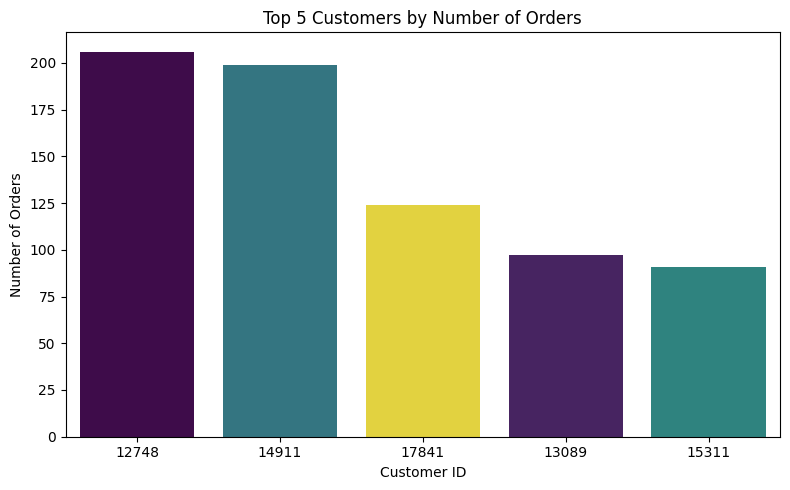

In [48]:
# Calculate top 5 customers by number of orders
top_customers_by_orders = (
    df_clean[df_clean['TransactionType'] == 'Sale']
    .groupby('CustomerID')['InvoiceNo']
    .nunique()
    .sort_values(ascending=False)
    .head(5)
    .reset_index(name='OrderCount')
)

# Sort customer IDs by order count
sorted_ids_orders = top_customers_by_orders.sort_values('OrderCount', ascending=False)['CustomerID']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_customers_by_orders,
    x='CustomerID',
    y='OrderCount',
    hue='CustomerID',
    order=sorted_ids_orders,
    palette='viridis',
    dodge=False,
    legend=False
)
plt.title('Top 5 Customers by Number of Orders')
plt.xlabel('Customer ID')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()


**Key Insights:**

- **Customer 12748** placed the highest number of orders (206), showing high frequency but did not appear in the top revenue list — suggesting **smaller, more frequent purchases**.
- Customers like **14911** are especially valuable as they combine **high order frequency and high revenue**, making them strong candidates for loyalty or VIP programs.
- Others, such as **17841** and **13089**, show consistent engagement, possibly contributing to steady monthly revenue.

## Customer Behavior and RFM *(Rencency, Frequency, Moneteary)* Analysis


Understanding customer behavior is essential for targeting marketing efforts, optimizing customer retention strategies, and identifying valuable customer segments. In this section, we perform an **RFM (Recency, Frequency, Monetary) analysis** using transaction data from valid customers.

We begin by visualizing the distribution of the three RFM variables:

- **Recency**: Days since the last purchase.
- **Frequency**: Number of purchase transactions.
- **Monetary**: Total revenue generated.


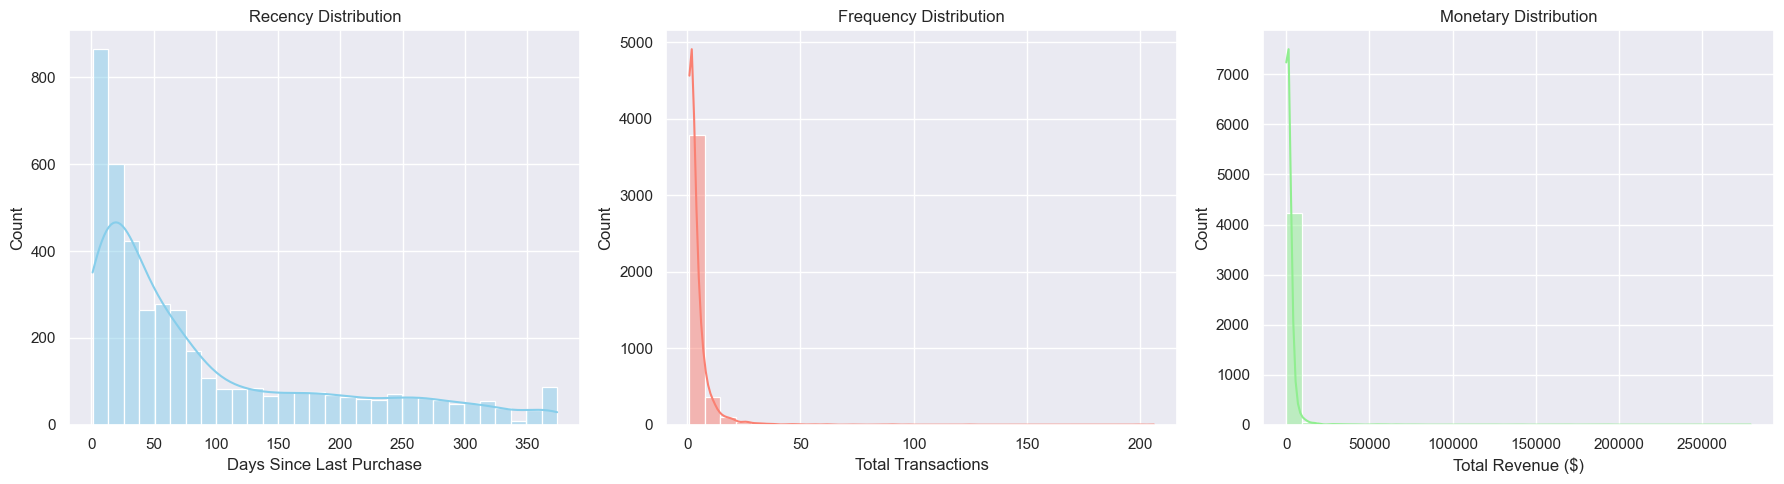

In [49]:
# Set style to dark
sns.set(style="darkgrid")

# Plotting the three distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency
sns.histplot(df_rfm['Recency'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days Since Last Purchase')

# Frequency
sns.histplot(df_rfm['Frequency'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Total Transactions')

# Monetary
sns.histplot(df_rfm['Monetary'], bins=30, kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Total Revenue ($)')

plt.tight_layout()
plt.show()

The distribution of RFM variables reveals the underlying behavior patterns of customers:

- **Recency** shows a strong peak around recent purchases, with a long tail of dormant users.
- **Frequency** is sharply skewed, with most customers purchasing only once.
- **Monetary** is positively skewed, indicating a few customers contribute disproportionately to revenue.

These skewed distributions are common in retail datasets and help uncover valuable insights into customer heterogeneity.

To compare customers consistently, we assign each RFM variable a score from **1 to 5** using quantile binning:

- Customers with **recent purchases** get a **higher Recency score** (5 is best).
- Those with more **frequent purchases** get a higher Frequency score.
- Customers who spent more money receive a higher Monetary score.

These individual scores are then used to calculate:
- **RFM_Segment**: A combined string like "543" for classification.
- **RFM_Score**: The sum of the three scores (range: 3 to 15) for easier ranking.

In [50]:
# Create quantile scores
df_rfm['R_Score'] = pd.qcut(df_rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
df_rfm['F_Score'] = pd.qcut(df_rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
df_rfm['M_Score'] = pd.qcut(df_rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Create RFM segment code (optional)
df_rfm['RFM_Segment'] = df_rfm['R_Score'].astype(str) + df_rfm['F_Score'].astype(str) + df_rfm['M_Score'].astype(str)

# Create RFM score for ranking
df_rfm['RFM_Score'] = df_rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

We define customer segments based on their total **RFM_Score**, grouping them into strategic categories:

- **Champions** (13–15): Recent, frequent, high spenders.
- **Loyal Customers** (10–12): Regulars with good value.
- **Potential Loyalists** (7–9): Worth nurturing.
- **Needs Attention** (4–6): Low activity/value.
- **At Risk** (below 4): Disengaged or lost.

In [51]:
def segment_customer(score):
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal Customers'
    elif score >= 7:
        return 'Potential Loyalists'
    elif score >= 4:
        return 'Needs Attention'
    else:
        return 'At Risk'

df_rfm['Segment'] = df_rfm['RFM_Score'].apply(segment_customer)


The bar chart below visualizes how many customers fall into each total RFM score:

- Most customers are concentrated in the **5–10 score range**, with fewer in the highest-value tiers.
- This validates the earlier skewed histograms — a few customers are highly engaged or valuable.

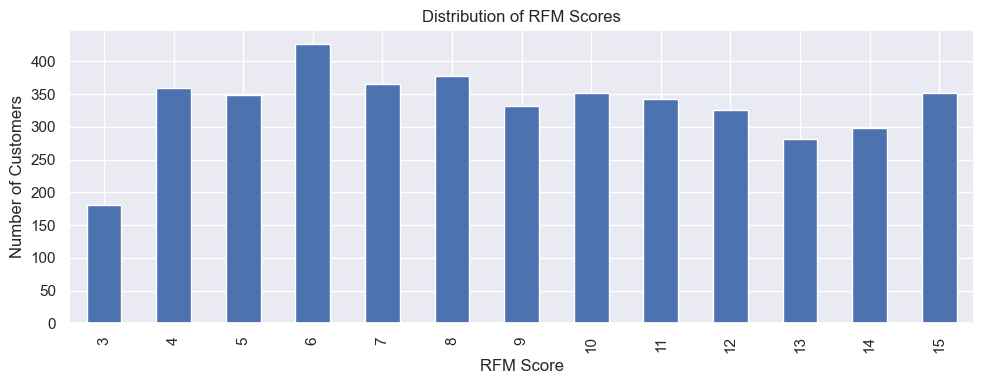

In [52]:
df_rfm['RFM_Score'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(10, 4),
    title='Distribution of RFM Scores',
    xlabel='RFM Score',
    ylabel='Number of Customers'
)
plt.tight_layout()
plt.show()


Next, we group and visualize the customer base by their assigned segment labels:

- **Champions** and **Loyal Customers** together form a high-value core.
- A substantial number are **Potential Loyalists**, offering good growth potential.
- Customers in **Needs Attention** and **At Risk** could benefit from reactivation strategies.

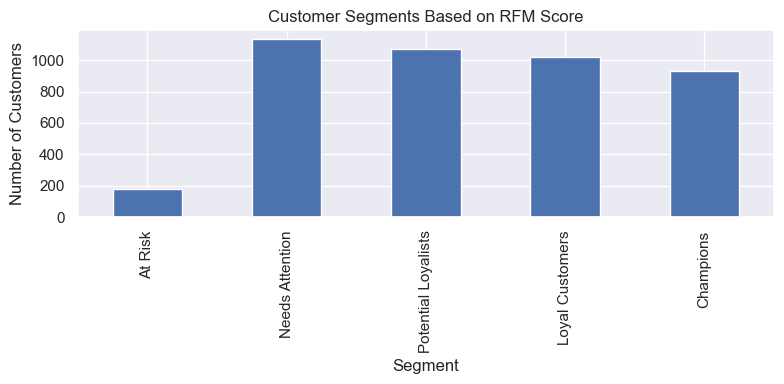

In [53]:
# Get value counts and reindex to ensure the segments are in a logical order
segment_counts = df_rfm['Segment'].value_counts().reindex(['At Risk', 'Needs Attention', 'Potential Loyalists', 'Loyal Customers','Champions'])

# Plot with ordered segments
segment_counts.plot(
    kind='bar',
    title='Customer Segments Based on RFM Score',
    ylabel='Number of Customers',
    xlabel='Segment',
    figsize=(8,4)
)

plt.tight_layout()
plt.show()

### Customer Behavior/RFM Insights

**Recency – Days Since Last Purchase**
- **Insight:** The distribution is heavily right-skewed, with a peak in the 0–50 day range. This indicates a strong base of recently active customers, while a long tail suggests many dormant or disengaged accounts.
- **Implication:** Customers with Recency ≤ 30 days could be ideal for loyalty programs or upselling. Those inactive for over 90 days may benefit from reactivation campaigns with personalized offers.

**Frequency – Total Transactions**
- **Insight:** The vast majority of customers made only 1–2 purchases, forming a sharp left-sided peak. A small fraction shows significantly higher transaction counts.
- **Implication:** Focus on converting one-time buyers into repeat customers with follow-up incentives. Recognize and retain high-frequency buyers through exclusive perks or early access programs.

**Monetary – Total Revenue ($)**
- **Insight:** Revenue per customer is highly skewed, with most contributing modest amounts. A small group of customers generates a disproportionately high share of the revenue.
- **Implication:** Identify and prioritize the top 5–10% of high spenders for VIP treatment. Mid-tier spenders can be nurtured using targeted product recommendations, bundling, or loyalty points systems.

---

**Strategic Takeaways from RFM Segmentation**

- A relatively small group of customers has an outsized impact on overall revenue.
- Many customers are inactive, infrequent buyers, or low spenders — but can be re-engaged or educated into higher value segments.
- RFM scoring reveals clear opportunities for **segmentation-driven marketing**:  
  - **Champions** and **Loyal Customers** deserve retention and appreciation strategies.  
  - **Potential Loyalists** can be cultivated through timely, personalized engagement.  
  - **At Risk** and **Needs Attention** customers present reactivation opportunities.

This lays the groundwork for tailored customer strategies that align marketing efforts with customer value and behavior.
